<h1><center>Python Lunch</center></h1>
<center><img src="images/python_lunch.png"></center>
<h2><center>Asynchronous code in python</center></h2>
<h3><center>multithreading, multiprocessing, event loop and the GIL</center></h3>









<center><img src="images/why.jpg"></center>

# 1. A bit of history
## Batch processing
https://www.computerhistory.org/revolution/punched-cards/2/211/2253
<center><img src="images/batch_processing.png"></center>



Computers used to run in batches.

This meant that programs where given and run sequentially.

Often the queue for the computer was long and you sometimes had to wait multiple days to get your results.

Not ideal when trying to debug your application.

## Time sharing computers

<center><img src="images/timesharing.jpg"></center>

Time sharing allows multiple users to debug at the same time, maximising the use of expensive computers.

Unfortunately this creates new problems, with multiple users/processes sharing resources (memory/files). The question of access management and scheduling come into the picture.

It is in this context that unix is born. It's a time sharing system that allows fine **controlled file access** and **isolated memory spaces**.

## Multi(tasking)processing is born
<center><img src="images/multiprocessing.jpeg"></center>

### Wouldn't it be great if I could share memory between two processes instead of having to pass messages?
* Multi-threading is born 
  * Green threads
  * kernel threads

In [9]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import glob
from PIL import Image
import random
import string
%matplotlib inline

In [10]:
MULTITHREADING_TITLE="Multithreading"
MULTIPROCESSING_TITLE="Multiprocessing"

def visualize_runtimes(results, title):
    start,stop = np.array(results).T
    plt.barh(range(len(start)),stop-start,left=start)
    plt.grid(axis='x')
    plt.ylabel("Tasks")
    plt.xlabel("Seconds")
    plt.title(title)
    return stop[-1]-start[0]

In [11]:
def multithreading(func, args, workers):
    begin_time = time.time()
    with ThreadPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, args, [begin_time for i in range(len(args))])
    return list(res)
        
def multiprocessing(func, args, workers):
    begin_time = time.time()
    with ProcessPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, args, [begin_time for i in range(len(args))])
    return list(res)

<center><h1>First example API Calls</h1></center>
<center><h3>Network latency</h3></center>

In [28]:
from urllib.request import urlopen

def download(url, base):
    start = time.time() - base
    try:
        resp = urlopen(url)
    except Exception as e:
        print ('ERROR: %s' % e)
    stop = time.time() - base
    return start,stop

In [29]:
N = 16
URL = 'http://scholar.princeton.edu/sites/default/files/oversize_pdf_test_0.pdf'
urls = [URL for i in range(N)]

<center><h3>Serial</h3></center>

14.866183042526245

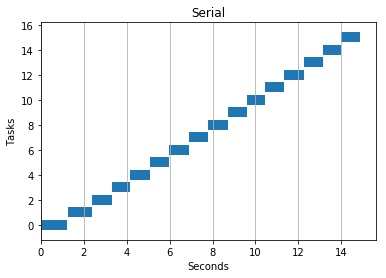

In [6]:
begin_time = time.time()
api_call_serial = visualize_runtimes([download(url, begin_time) for url in urls], 'Serial')
api_call_serial

<center><h3>Multithreading</h3></center>

15.7963414192
8.22337222099
4.97830271721


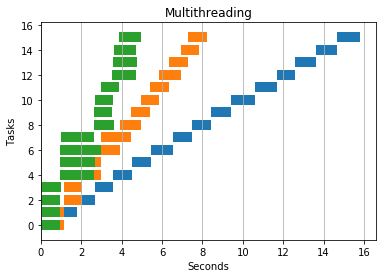

In [7]:
api_call_mt_1 = visualize_runtimes(multithreading(download, urls, 1), "Single Thread")
print(api_call_mt_1)

api_call_mt_2 = visualize_runtimes(multithreading(download, urls, 2),MULTITHREADING_TITLE)
print(api_call_mt_2)

api_call_mt_4 = visualize_runtimes(multithreading(download, urls, 4),MULTITHREADING_TITLE)
print(api_call_mt_4)

<center><h3>Multiprocessing</h3></center>

17.1885671616
9.76101279259
6.05080461502


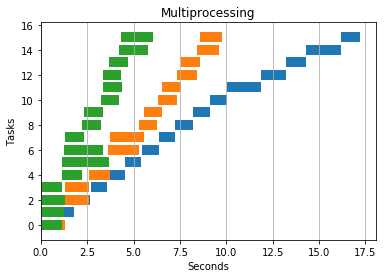

In [8]:
api_call_mp_1 = visualize_runtimes(multiprocessing(download, urls, 1), "Single Process")
print(api_call_mp_1)

api_call_mp_2 = visualize_runtimes(multiprocessing(download, urls, 2), MULTIPROCESSING_TITLE)
print(api_call_mp_2)

api_call_mp_4 = visualize_runtimes(multiprocessing(download, urls, 4), MULTIPROCESSING_TITLE)
print(api_call_mp_4)

<center><h3>Conclusion</h3></center>

In [9]:
pd.DataFrame({
    'Serial': [api_call_serial, None, None],
    'Threads': [api_call_mt_1, api_call_mt_2, api_call_mt_4],
    'Processes': [api_call_mp_1, api_call_mp_2, api_call_mp_4]
})[['Serial', 'Threads', 'Processes']]

,Serial,Threads,Processes
0,14.866183,15.796341,17.188567
1,NaN,8.223372,9.761013
2,NaN,4.978303,6.050805


For blocking IO tasks (network, disk read, waiting for user input). Multi-threading and multi processing are extremely effective.

<center><h1>Hitting the GIL</h1></center>


## What is the GIL

* Python uses reference counts in order to do garbage collection (A whole other topic).


In [10]:
import sys

a = 'TOTO'
print("a -> ", sys.getrefcount(a))
b = a
print("b -> ", sys.getrefcount(b))
a = None
print("b -> ", sys.getrefcount(b))

a ->  3
b ->  4
b ->  3


* The GIL makes this garbage collection:
    * fast
    * simple
    * thread safe


https://realpython.com/python-gil/

<center><h1><bold>BUT</bold></h1></center>
<center><h3>Only one thread can use the python interpreter at the same time !!!</h3></center>

In [11]:
COUNT = 50000000

def countdown(n, base):
    start = time.time() - base
    while n>0:
        n -= 1
    stop = time.time() - base
    return start,stop
    
N = 16
COUNTS = [COUNT for i in range(N)]

import sys
print(sys.getrefcount(COUNT))

19


<center><h3>Serial</h3></center>

43.196173191070557

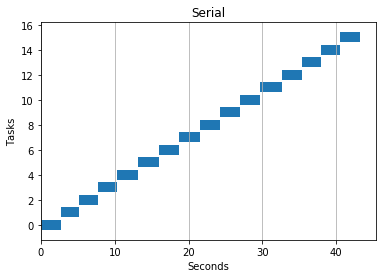

In [12]:
begin_time = time.time()
cd_serial = visualize_runtimes([countdown(_, begin_time) for _ in COUNTS], 'Serial')
cd_serial

<center><h3>Multithreading</h3></center>

44.2802989483
39.8211803436
41.1003158092


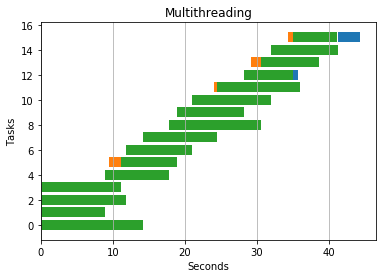

In [13]:
cd_mt_1 = visualize_runtimes(multithreading(countdown, COUNTS, 1), "Single Thread")
print(cd_mt_1)

cd_mt_2 = visualize_runtimes(multithreading(countdown, COUNTS, 2),MULTITHREADING_TITLE)
print(cd_mt_2)

cd_mt_4 = visualize_runtimes(multithreading(countdown, COUNTS, 4),MULTITHREADING_TITLE)
print(cd_mt_4)

<center><h3>Multiprocessing</h3></center>

42.7516133785
24.7859609127
15.5726885796


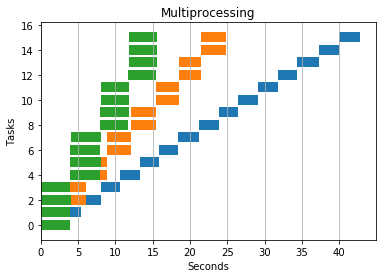

In [14]:
cd_mp_1 = visualize_runtimes(multiprocessing(countdown, COUNTS, 1), "Single Process")
print(cd_mp_1)

cd_mp_2 = visualize_runtimes(multiprocessing(countdown, COUNTS, 2), MULTIPROCESSING_TITLE)
print(cd_mp_2)

cd_mp_4 = visualize_runtimes(multiprocessing(countdown, COUNTS, 4), MULTIPROCESSING_TITLE)
print(cd_mp_4)

<center><h3>Conclusion</h3></center>

In [15]:
pd.DataFrame({
    'Serial': [cd_serial, None, None],
    'Threads': [cd_mt_1, cd_mt_2, cd_mt_4],
    'Processes': [cd_mp_1, cd_mp_2, cd_mp_4]
})[['Serial', 'Threads', 'Processes']]

,Serial,Threads,Processes
0,43.196173,44.280299,42.751613
1,NaN,39.821180,24.785961
2,NaN,41.100316,15.572689


For cpu intensive tasks in python. Threading will not bring any performance boost.

<img src="images/dont_thread.png">
<center>Or alternatively you can try using an alternative python interpreter (Pypy, Jython, Ironpython)</center>
<center>Or wait for the <a href="https://lwn.net/Articles/754577/">Gilectomy</a></center>

<center><img src="images/multi_every.jpg"></center>

In [16]:
def message_passing(text,base):
    start = time.time() - base
    f = open('output.txt', 'wt', encoding='utf-8')
    f.write(text)
    f.close()
    stop = time.time() - base
    return start,stop

In [17]:
N=30
TEXT = ''.join(random.choice(string.ascii_lowercase) for i in range(10**8))

<center><h3>Serial</h3></center>

13.3762421608


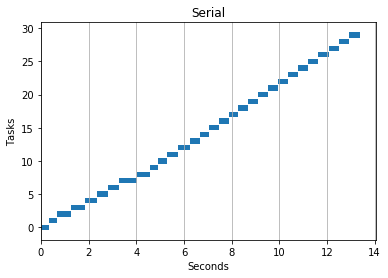

In [18]:
begin_time = time.time()
io_serial = visualize_runtimes([message_passing(TEXT, begin_time) for i in range(N)],"Serial")
print(io_serial)

<center><h3>Multithreading</h3></center>

14.4636187553
6.25122141838
4.20003652573


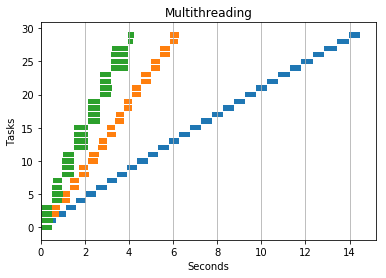

In [19]:
io_mt1 = visualize_runtimes(multithreading(message_passing, [TEXT for i in range(N)], 1),"Single Thread")
print(io_mt1)

io_mt2 = visualize_runtimes(multithreading(message_passing, [TEXT for i in range(N)], 2),MULTITHREADING_TITLE)
print(io_mt2)

io_mt4 = visualize_runtimes(multithreading(message_passing, [TEXT for i in range(N)], 4),MULTITHREADING_TITLE)
print(io_mt4)

<center><h3>Multiprocessing</h3></center>

14.6610298157
8.19692659378
6.33686828613


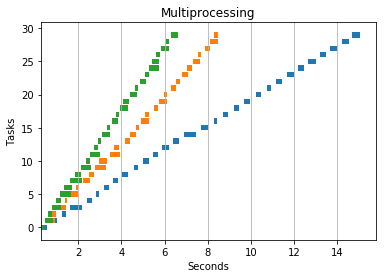

In [20]:
io_mp1 = visualize_runtimes(multiprocessing(message_passing, [TEXT for i in range(N)], 1),"Single Process")
print(io_mp1)

io_mp2 = visualize_runtimes(multiprocessing(message_passing, [TEXT for i in range(N)], 2),MULTIPROCESSING_TITLE)
print(io_mp2)

io_mp4 = visualize_runtimes(multiprocessing(message_passing, [TEXT for i in range(N)], 4),MULTIPROCESSING_TITLE)
print(io_mp4)

# Results message passing

In [21]:
pd.DataFrame({
    'Serial': [io_serial, None, None],
    'Threads': [io_mt1, io_mt2, io_mt4],
    'Processes': [io_mp1, io_mp2, io_mp4]
})[['Serial', 'Threads', 'Processes']]

,Serial,Threads,Processes
0,13.376242,14.463619,14.661030
1,NaN,6.251221,8.196927
2,NaN,4.200037,6.336868


Threads share memory, there is no cost of message passing.
Multiprocess must pass message between each other which might lead to losing (parts of) the gains of using multi processing.

# Exploiting the specificities of Linux
#### This will NOT work on windows.
<center><img src="images/forking.gif"></center>

I'm no longer passing the variable across process, instead I use a variable that is part of the parent process's context.
It is therefore transfered to the child procesees almost free of charge thanks to **copy on write**.

In [22]:
with open('my_global.py', 'w') as fp:
    fp.write("""
import random
import string

TEXT = ''.join(random.choice(string.ascii_lowercase) for i in range(10**8))
    """)

In [23]:
import my_global

In [24]:
def bound_io_heavy(_, base):
    start = time.time() - base
    f = open('output.txt', 'wt', encoding='utf-8')
    f.write(my_global.TEXT)
    f.close()
    stop = time.time() - base
    return start,stop

12.397462368
6.4051835537
4.05155062675


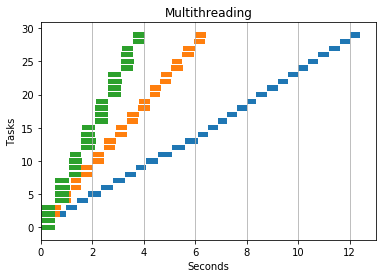

In [25]:
bio_mt1 = visualize_runtimes(multithreading(bound_io_heavy, [i for i in range(N)], 1),"Single Thread")
print(bio_mt1)

bio_mt2 = visualize_runtimes(multithreading(bound_io_heavy, [i for i in range(N)], 2),MULTITHREADING_TITLE)
print(bio_mt2)

bio_mt4 = visualize_runtimes(multithreading(bound_io_heavy, [i for i in range(N)], 4),MULTITHREADING_TITLE)
print(bio_mt4)

14.1506607533
5.66581606865
5.06301736832


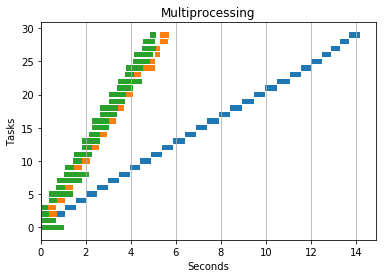

In [26]:
bio_mp1 = visualize_runtimes(multiprocessing(bound_io_heavy, [i for i in range(N)], 1),"Single Process")
print(bio_mp1)

bio_mp2 = visualize_runtimes(multiprocessing(bound_io_heavy, [i for i in range(N)], 2),MULTIPROCESSING_TITLE)
print(bio_mp2)

bio_mp4 = visualize_runtimes(multiprocessing(bound_io_heavy, [i for i in range(N)], 4),MULTIPROCESSING_TITLE)
print(bio_mp4)

<h1>Conclusions</h1>

In [27]:
pd.DataFrame({
    'Serial': [io_serial, None, None],
    'Threads': [io_mt1, io_mt2, io_mt4],
    'Processes': [io_mp1, io_mp2, io_mp4],
    'bThreads': [bio_mt1, bio_mt2, bio_mt4],
    'bProcesses': [bio_mp1, bio_mp2, bio_mp4]

})[['Serial', 'Threads', 'Processes', 'bThreads', 'bProcesses']]

,Serial,Threads,Processes,bThreads,bProcesses
0,13.376242,14.463619,14.661030,12.397462,14.150661
1,NaN,6.251221,8.196927,6.405184,5.665816
2,NaN,4.200037,6.336868,4.051551,5.063017


Slight increase in perfomance for the processes (not conclusive)

<center><h1>Numpy Functions</h1></center>
<center><h3>Now for some weird things.</h3></center>

### Numpy Addition

* Does not use parallel processing by default
* But will see speedups if multiprocessing used
* Because numpy sidesteps python's GIL

In [13]:
def addition(i, base):
    start = time.time() - base
    res = a + b
    stop = time.time() - base
    return start,stop

DIMS = 5000
N = 20
DIMS_ARR = [DIMS for i in range(N)]
a = np.random.rand(DIMS,DIMS)
b = np.random.rand(DIMS,DIMS)

<center><h1>Serial</h1></center>

1.3918697834


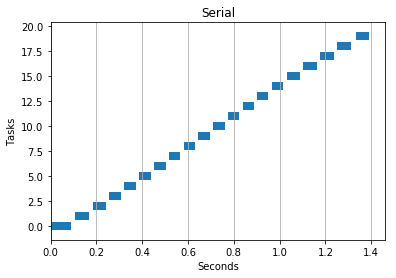

In [14]:
begin_time = time.time()
np_add_serial = visualize_runtimes([addition(i, begin_time) for i in range(N)],"Serial")
print(np_add_serial)

<center><h1>Multithreading</h1></center>

1.37486457825
1.2666785717


1.3600711822509766

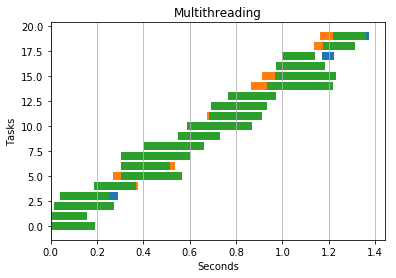

In [15]:
np_add_mt1 = visualize_runtimes(multithreading(addition, [i for i in range(N)], 1),"Single Thread")
print(np_add_mt1)

np_add_mt2 = visualize_runtimes(multithreading(addition, [i for i in range(N)], 2),MULTITHREADING_TITLE)
print(np_add_mt2)

np_add_mt4 = visualize_runtimes(multithreading(addition, [i for i in range(N)], 4),MULTITHREADING_TITLE)
np_add_mt4

<center><h1>Multiprocessing</h1></center>

1.29243421555
1.33252429962
1.43088436127


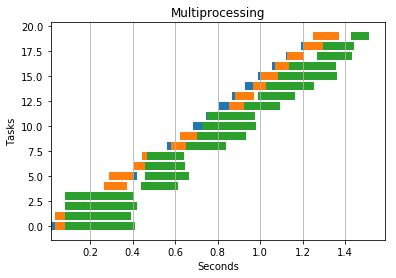

In [16]:
np_add_mp1 = visualize_runtimes(multiprocessing(addition, [i for i in range(N)], 1),"Single Process")
print(np_add_mp1)

np_add_mp2 = visualize_runtimes(multiprocessing(addition, [i for i in range(N)], 2),MULTIPROCESSING_TITLE)
print(np_add_mp2)

np_add_mp4 = visualize_runtimes(multiprocessing(addition, [i for i in range(N)], 4),MULTIPROCESSING_TITLE)
print(np_add_mp4)


<center><h1>Conclusion</h1></center>
<center>Some benefit for numpy addition (operation avoids GIL, but not parallel by default)</center>

In [17]:
pd.DataFrame({
    'Serial': [np_add_serial, None, None],
    'Threads': [np_add_mt1, np_add_mt2, np_add_mt4],
    'Processes': [np_add_mp1, np_add_mp2, np_add_mp4],
})[['Serial', 'Threads', 'Processes']]

,Serial,Threads,Processes
0,1.39187,1.374865,1.292434
1,NaN,1.266679,1.332524
2,NaN,1.360071,1.430884


Multi processing should improve slightly but I'm having memory issues so I think the cost of multiprocessing is bigger than the gain.

### Dot Product

#### Automatic parallel processing built works out of the box
#### Depending on BLAS impl, MKL (default with anaconda3) does
#### Should NOT see speedups with multithreading/processing

In [18]:

def dot_product(i, base):
    start = time.time() - base
    res = np.dot(a,b)
    stop = time.time() - base
    return start,stop

DIMS = 3000
N = 10
DIMS_ARR = [DIMS for i in range(N)]
a = np.random.rand(DIMS,DIMS)
b = np.random.rand(DIMS,DIMS)

<center><h1>Serial</h1></center>

4.86350107193


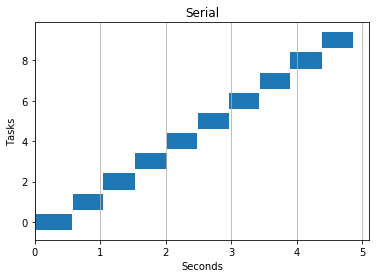

In [21]:
begin_time = time.time()
np_dot_serial = visualize_runtimes([dot_product(i, begin_time) for i in range(N)],"Serial")
print(np_dot_serial)

<center><h1>Multithreading</h1></center>


4.98927474022
5.01878452301
9.03310418129


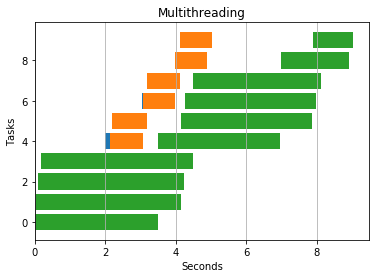

In [22]:
np_dot_mt1 = visualize_runtimes(multithreading(dot_product, [i for i in range(N)], 1),"Single Thread")
print(np_dot_mt1)

np_dot_mt2 = visualize_runtimes(multithreading(dot_product, [i for i in range(N)], 2),MULTITHREADING_TITLE)
print(np_dot_mt2)

np_dot_mt4 = visualize_runtimes(multithreading(dot_product, [i for i in range(N)], 4),MULTITHREADING_TITLE)
print(np_dot_mt4)

<center><h1>Multiprocessing</h1></center>

5.41053652763
5.38284492493
6.94524621964


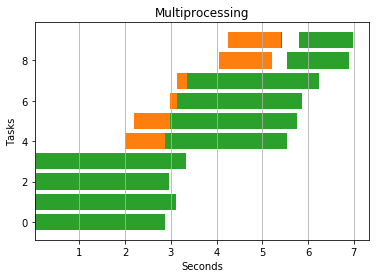

In [24]:
np_dot_mp1 = visualize_runtimes(multiprocessing(dot_product, [i for i in range(N)], 1),"Single Process")
print(np_dot_mp1)

np_dot_mp2 = visualize_runtimes(multiprocessing(dot_product, [i for i in range(N)], 2),MULTIPROCESSING_TITLE)
print(np_dot_mp2)

np_dot_mp4 = visualize_runtimes(multiprocessing(dot_product, [i for i in range(N)], 4),MULTIPROCESSING_TITLE)
print(np_dot_mp4)

<center><h1>Conclusion</h1></center>
<center>No benefit on dot product (since already parallel)</center>

In [25]:
pd.DataFrame({
    'Serial': [np_dot_serial, None, None],
    'Threads': [np_dot_mt1, np_dot_mt2, np_dot_mt4],
    'Processes': [np_dot_mp1, np_dot_mp2, np_dot_mp4],
})[['Serial', 'Threads', 'Processes']]

,Serial,Threads,Processes
0,4.863501,4.989275,5.410537
1,NaN,5.018785,5.382845
2,NaN,9.033104,6.945246


<center><h1>Asyncio</h1></center>
<center>Event loop</center>

In [124]:
import aiohttp
import asyncio

async def async_download(session, url, base):
    start = time.time() - base
    async with session.get(url) as response:
        resp = response.text()
        stop = time.time() - base
        return start,stop
            
    
async def main():
    async with aiohttp.ClientSession() as session:
        begin_time = time.time()
        results = await asyncio.gather(*[
            async_download(session, url, begin_time) for url in urls
        ])
        print(results)
        visualize_runtimes(results, 'ASYNC IO')

loop = asyncio.get_event_loop()
task = loop.create_task(main())
future = loop.create_future()

[(0.004415273666381836, 8.357598781585693), (0.009404659271240234, 7.852656841278076), (0.016423463821411133, 7.848320960998535), (0.02384471893310547, 10.837506532669067), (0.010811328887939453, 7.805081605911255), (0.019449710845947266, 8.740798234939575), (0.020218849182128906, 7.851454973220825), (0.017194509506225586, 5.364452362060547), (0.0012633800506591797, 9.043578386306763), (0.0030248165130615234, 7.850981712341309), (0.015553712844848633, 1.5862011909484863), (0.005736112594604492, 7.7730395793914795), (0.01184391975402832, 7.849290609359741), (0.008010149002075195, 1.6423323154449463), (0.01858973503112793, 1.5983083248138428), (0.02298736572265625, 10.804126262664795)]


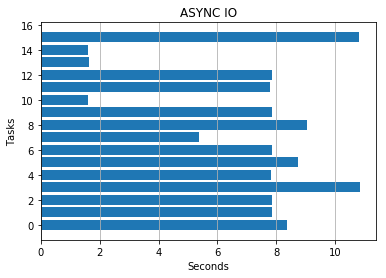

In [125]:
task.result()

You have to use compatible libraries (alternative is greenlet that monkey patches blocking standard library calls.)
Results should be similar to multithreading without the cost of making threads.


<center><h1>Conclusion</h1></center>
<center><img src="images/profile_it.png"></center>

Multi processing might help you ... or not.

It's not a silver bullet. Measure it.